Plotting notebook to accompany "Idea engine: A unified theory of innovation and obsolescence from markets and genetic evolution to science" written by Edward D. Lee, Christopher P. Kempes, and Geoffrey B. West.

Notebook author Edward D. Lee, edlee@csh.ac.at

Published on https://github.com/eltrompetero/innovation

In [44]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/eddie/anaconda3/envs/innov/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plot', 'f', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [45]:
plt.rc('font', size=20)

In [46]:
from scipy.signal import fftconvolve
from matplotlib.patches import Rectangle
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
from matplotlib import colors

from innov import *
from innov.simple_model import *
from innov.genome import *

imgdr = os.path.expanduser('~')+'/Dropbox/Research/innov/writing/20220125_draft'
assert os.path.isdir(imgdr)

def load_critical_sample(no):
    with open(f'critical_sample{no}.p', 'rb') as file:
        data = pickle.load(file)
        L = array(data['L'])
        n0 = array(data['n0'])
    return L, n0

# Figure 2: Automaton example

In [119]:
# example values of obsolescence rate ro to show
ro_range = [0, .5, 1.]

def loop_wrapper(ro):
    simulator = UnitSimulator(4, ro, .395, .4, .9, .01,
                              rng=np.random.RandomState(int(ro*100)))
    occupancy = [simulator.simulate(0)]
    for i in range(5_000):
        occupancy.append(simulator.simulate(1, occupancy=occupancy[-1]))
    L = np.array([len(i) for i in occupancy])
    n0 = np.array([i[-1] for i in occupancy])
    n = np.vstack([i[-21:][::-1]+[0]*(21-len(i)) for i in occupancy[-1000:]]).mean(0)
    nerr = np.vstack([i[-21:][::-1]+[0]*(21-len(i)) for i in occupancy[-1000:]]).std(0)
    return L, n0, n, nerr

with Pool(3) as pool:
    Ltraj, n0traj, n, nerr = list(zip(*pool.map(loop_wrapper, ro_range)))

/home/eddie/Dropbox/Research/innov/py/pyutils/simple_model.py:1275: RuntimeWarning: divide by zero encountered in double_scalars
  return -G_bar / (ro_bar/I * ((1+1/(1-C))/(Q-1) - rd_bar - ro_bar/(1-C)))


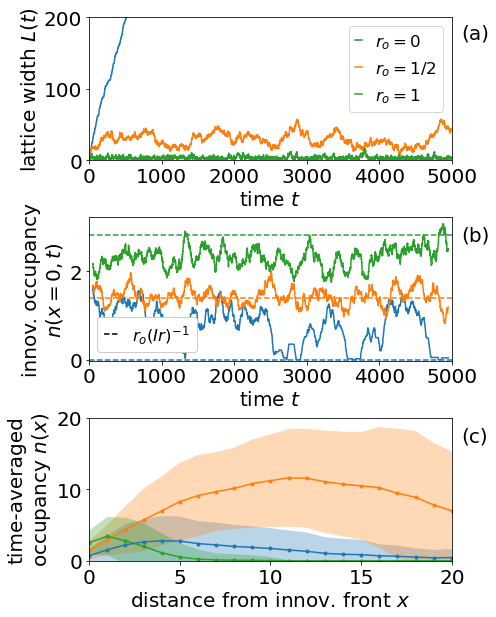

In [120]:
fig, ax = plt.subplots(figsize=(6.5,10), nrows=3, gridspec_kw={'hspace':.4})
for y in Ltraj:
    ax[0].plot(y)
    
ax[0].legend((r'$r_o=0$',r'$r_o=1/2$',r'$r_o=1$'),
             handlelength=.4, loc=1, fontsize='small')
ax[0].set(xlabel=r'time $t$', ylabel=r'lattice width $L(t)$', xlim=(0, len(y)-1), ylim=(0, 200))

h = []
window = 100
for i, (y, ro) in enumerate(zip(n0traj, [0,.5,1.])):
    h.append(ax[1].plot(range(window//2, len(y)-window//2+1),
                        fftconvolve(y, ones(window)/window, mode='valid'))[0])
    h.append(ax[1].hlines(ro/.395/.9, 0, 10_000, color=f'C{i}',linestyles='--'))
ax[1].set(xlabel=r'time $t$', ylabel='innov. occupancy\n'+r'$n(x=0,t)$', xlim=(0, len(y)-1),
          ylim=(-.02,3.22))
h = [Line2D([], [], linestyle='--', color='k')]
ax[1].legend(h, (r'$r_o(I r)^{-1}$',), handlelength=.9, fontsize='small',
             loc=3, framealpha=1)

# occupancy number
h = []
for n_, nerr_ in zip(n, nerr):
    h.append(ax[2].plot(range(21), n_, '.-')[0])
    ax[2].fill_between(range(21), n_-nerr_, n_+nerr_, alpha=.3)

ax[2].set(ylim=(0, 20), xlim=(0, 20),
          xlabel=r'distance from innov. front $x$',
          ylabel='time-averaged\n'+r'occupancy $n(x)$')

fig.text(.92, .85, '(a)')
fig.text(.92, .57, '(b)')
fig.text(.92, .29, '(c)')

fig.savefig(f'{imgdr}/sim_example.pdf', bbox_inches='tight')

# Figure 3: Regimes of phase space

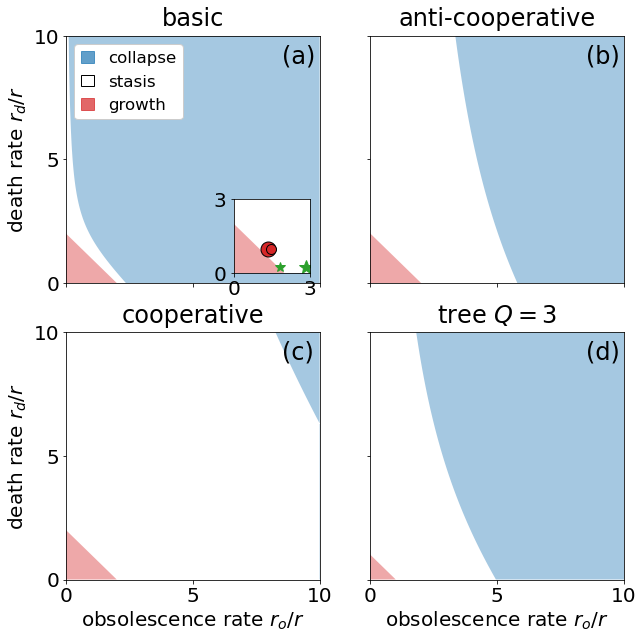

In [115]:
G, ro, rd, I, dt, a, b = iplot.jangili_params(0).values()

# these should all be points at which the lattice diverges
fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, sharex=True, sharey=True)
ax = ax.ravel()
axins = inset_axes(ax[0], '30%', '30%', 'lower right')

# linear approx to 1st order boundaries
rd_range = linspace(0, 10, 100)
ro_range = 2 - rd_range
ax[0].fill_between(ro_range, zeros_like(rd_range), rd_range, fc='C3', alpha=.4)
axins.fill_between(ro_range, zeros_like(rd_range), rd_range, fc='C3', alpha=.4)

ro_range = 1 - rd_range/2 + np.sqrt((1-rd_range/2)**2+G*I/4)
ax[0].fill_betweenx(rd_range, ro_range, ones_like(ro_range)*10, fc='C0', alpha=.4)

# show examples
axins.plot(ro, rd, '*', c='C2', ms=10)
G, ro, rd, I, dt, a, b = iplot.jangili_params(1).values()
axins.plot(ro, rd, '*', c='C2', ms=15)

G, ro, rd, I, dt, a, b = iplot.prb_params(1).values()
axins.plot(ro, rd, 'o', c='C3', ms=10, mew=1, mec='k', zorder=2)
G, ro, rd, I, dt, a, b = iplot.prb_params(3).values()
axins.plot(ro, rd, 'o', c='C3', ms=15, mew=1, mec='k', zorder=1)

axins.set(xlim=(0,3), ylim=(0,3), xticks=[0,3], yticks=[0,3])

custom_lines = [Rectangle([0,0], 1, 1, color='C0', alpha=.7),
                Rectangle([0,0], 1, 1, fc='white', ec='k', lw=1),
                Rectangle([0,0], 1, 1, color='C3', alpha=.7)]

ax[0].legend(custom_lines, ['collapse', 'stasis', 'growth'],
             handlelength=.8, framealpha=1, fontsize='small', loc=2)

ax[0].set(ylabel=r'death rate $r_d/r$', xlim=(0,10), ylim=(0,10),
          xticks=[0,5,10], yticks=[0,5,10])
ax[2].set(xlabel=r'obsolescence rate $r_o/r$',
          ylabel=r'death rate $r_d/r$')
ax[3].set(xlabel=r'obsolescence rate $r_o/r$')

ax[0].set_title('basic', pad=10)
ax[1].set_title(r'anti-cooperative', pad=10)
ax[2].set_title('cooperative', pad=10)
ax[3].set_title(f'tree $Q=3$', pad=10)

ax[0].text(8.5, 8.9, '(a)', fontsize='large')
ax[1].text(8.5, 8.9, '(b)', fontsize='large')
ax[2].text(8.5, 8.9, '(c)', fontsize='large')
ax[3].text(8.5, 8.9, '(d)', fontsize='large')

# subplots
iplot.phase_space_variations(ax[1:], plot_range=[0,1,3])

fig.savefig(f'{imgdr}/compare_phase_space.pdf', bbox_inches='tight')

In [154]:
def solve_dist_to_div(G, ro_data, rd_data, I, Q=2, mx_ro=4):
    """Distance to divergence boundary in rescaled phase space with x-axis ro and y-axis rd.
    
    Parameters
    ----------
    
    Returns
    -------
    dict
    """
    
    def growth_fit_cost(ro):
        return (ro - ro_data)**2 + (rd_data - 2/(Q-1) + ro)**2
    growth_ro_soln = minimize(growth_fit_cost, 1.5, bounds=[(0, mx_ro)])

    assert growth_ro_soln['x']!=mx_ro and growth_ro_soln['x']!=1 and growth_ro_soln['x']!=0
    assert growth_ro_soln['success']
    return growth_ro_soln

dist_to_div = []

G, ro, rd, I, dt, a, b = iplot.iwai_params().values()
sol = solve_dist_to_div(G, ro, rd, I)
dist_to_div.append(('iwai', sol['fun'][0]))

for i in range(2):
    G, ro, rd, I, dt, a, b = iplot.jangili_params(i).values()
    sol = solve_dist_to_div(G, ro, rd, I)
    dist_to_div.append(('jangili', sol['fun'][0]))

for i in range(2):
    G, ro, rd, I, dt, a, b, Q = iplot.covid_params(i).values()
    sol = solve_dist_to_div(G, ro, rd, I, Q)
    dist_to_div.append(('covid', sol['fun'][0]))

for i in range(2):
    G, ro, rd, I, dt, a, b = iplot.patent_params(i).values()
    sol = solve_dist_to_div(G, ro, rd, I)
    dist_to_div.append(('patent', sol['fun'][0]))

for i in range(4):
    G, ro, rd, I, dt, a, b = iplot.prb_params(i).values()
    sol = solve_dist_to_div(G, ro, rd, I)
    dist_to_div.append(('prb', sol['fun'][0]))

save_pickle(['dist_to_div'], 'cache/dist_to_div.p', True)

/home/eddie/Dropbox/Research/innov/py/innov/genome.py:90: UserWarning: n[0] not 0, it is 1
  # near the root
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 2
  ntot = n.sum()
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 1
  ntot = n.sum()
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 0
  ntot = n.sum()
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 3
  ntot = n.sum()


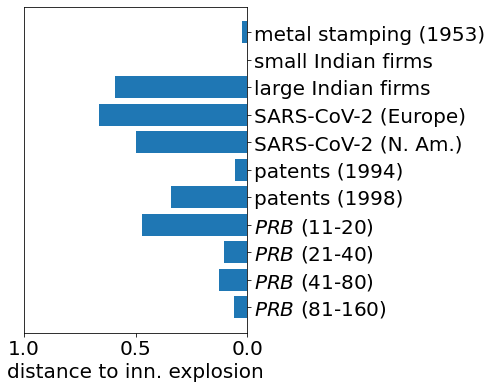

In [166]:
fig, ax = plt.subplots(figsize=(4,6))

ax.barh(range(len(dist_to_div)), [i[1] for i in dist_to_div][::-1])

ax.set(yticks=range(len(dist_to_div)),
       xlabel='distance to inn. explosion',
       xlim=(1,0))
ax.yaxis.set_ticks_position('right')
ax.set_yticklabels(['metal stamping (1953)',
                    'small Indian firms',
                    'large Indian firms',
                    'SARS-CoV-2 (Europe)',
                    'SARS-CoV-2 (N. Am.)',
                    'patents (1994)',
                    'patents (1998)',
                    r'$PRB$ (11-20)',
                    r'$PRB$ (21-40)',
                    r'$PRB$ (41-80)',
                    r'$PRB$ (81-160)'][::-1], ha='left')
fig.savefig(f'{imgdr}/distance.pdf', bbox_inches='tight')

# Figure 4: Data sets

In [69]:
from innov import *

In [70]:
covx, covy, br = covid_clades()

/home/eddie/Dropbox/Research/innov/py/innov/genome.py:90: UserWarning: n[0] not 0, it is 1
  # near the root
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 2
  ntot = n.sum()
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 1
  ntot = n.sum()
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 0
  ntot = n.sum()
/home/eddie/Dropbox/Research/innov/py/innov/genome.py:110: UserWarning: n[0] not 0, it is 3
  ntot = n.sum()


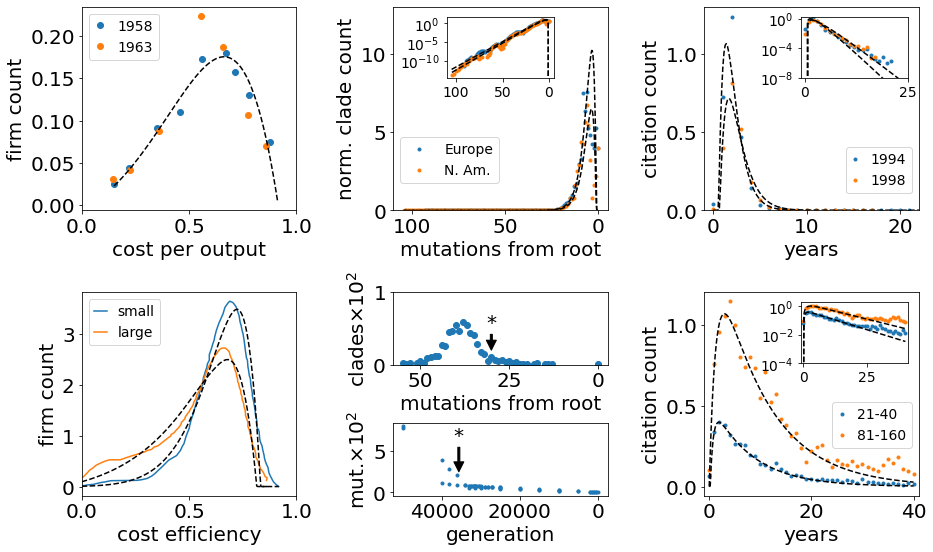

In [168]:
gs = GridSpec(2, 3, wspace=.45, hspace=.4)
gs_sub = GridSpecFromSubplotSpec(2, 1, gs[1,1], hspace=.8)
fig = plt.figure(figsize=(15,9))
ax = [fig.add_subplot(gs[0,0]),
      fig.add_subplot(gs[0,1]),
      fig.add_subplot(gs[0,2]),
      fig.add_subplot(gs[1,0]),
      fig.add_subplot(gs[1,2]),
      [fig.add_subplot(gs_sub[0]), fig.add_subplot(gs_sub[1])]]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # firms =========================================================
    data1958 = pd.read_csv('plotting/iwai1958.csv', header=None).values
    data1963 = pd.read_csv('plotting/iwai1963.csv', header=None).values
    ax[0].plot(data1958[:,0], data1958[:,1], 'o', zorder=0)
    ax[0].plot(data1963[:,0], data1963[:,1], 'o', zorder=0)
    f = iplot.fit_sol('iwai_0')
    xplot = np.linspace(0, 30.5, 200)
    h.append(ax[0].plot(xplot/29*(data1958[-1,0]-data1958[0,0]) + data1958[0,0], f(xplot),
                        'k--', zorder=1)[0])
    ax[0].set(xlim=(0, 1),
              xlabel='cost per output', ylabel='firm count')
    ax[0].legend(("1958", "1963"),
                 fontsize='x-small', handlelength=.9, loc='upper left')

    h = []
    data2014 = pd.read_csv('plotting/jangili2014_small.csv', header=None).values
    h.append(ax[3].plot(data2014[:,0], array(data2014[:,1]), '-', zorder=0)[0])
    f = iplot.fit_sol('jangili_0')
    xplot = np.linspace(0, 29, 200)
    h.append(ax[3].plot(xplot/29*data2014[:,0].max(), f(xplot), 'k--', zorder=1)[0])

    data2014 = pd.read_csv('plotting/jangili2014_large.csv', header=None).values
    h.append(ax[3].plot(data2014[:,0], array(data2014[:,1]), '-', zorder=0)[0])
    f = iplot.fit_sol('jangili_1')
    xplot = np.linspace(0, 29, 200)
    h.append(ax[3].plot(xplot/29*data2014[:,0].max(), f(xplot), 'k--', zorder=1)[0])
    ax[3].set(xlim=(0,1), xlabel='cost efficiency', ylabel='firm count')
    ax[3].legend([h[0],h[2],h[1],h[3]], ('small','large'), fontsize='x-small', handlelength=.9)


    # PRB citations ====================================================
    load_pickle('plotting/prb_citations_by_class.p')
    for y in [corrected_citation_rate_prb[1], corrected_citation_rate_prb[-1]]:
        ax[4].plot(arange(y.size), y, '.', zorder=0)
    xplot = np.linspace(0, 40, 200)
    f1 = iplot.fit_sol('prb_citations_1', rev=True)
    ax[4].plot(xplot, f1(xplot), 'k--', zorder=1)
    f3 = iplot.fit_sol('prb_citations_3', rev=True)
    ax[4].plot(xplot, f3(xplot), 'k--', zorder=1)

    ax[4].set(xlabel='years', ylabel='citation count', xlim=(-1,41))
    ax[4].legend(('21-40', '81-160'), loc=4,
                 fontsize='x-small',
                 handlelength=.6,
                 bbox_to_anchor=(1,.2))

    axins = ax[4].inset_axes((.45, .65, .5, .3))
    for y in [corrected_citation_rate_prb[1], corrected_citation_rate_prb[-1]]:
        axins.plot(arange(y.size), y, '.', zorder=0)
    axins.semilogy(xplot, f1(xplot), 'k--', zorder=1)
    axins.semilogy(xplot, f3(xplot), 'k--', zorder=1)
    axins.set(xlim=(-1,41), ylim=(1e-4, 2))
    [el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()];
    [el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()];


    # patent citations ===================================================
    x = linspace(0, 100, 1000)
    load_pickle('plotting/patents_1994.p')
    ax[2].plot(x, y, '.', zorder=0)
    load_pickle('plotting/patents_1998.p')
    ax[2].plot(x, y, '.', zorder=0)
    xplot = np.linspace(0, 25, 200)
    f1 = iplot.fit_sol('patent_citations_0', rev=True)
    f2 = iplot.fit_sol('patent_citations_1', rev=True)
    ax[2].plot(xplot, f1(xplot), 'k--', zorder=1)
    ax[2].plot(xplot, f2(xplot), 'k--', zorder=1)
    ax[2].set(xlabel='years', ylabel='citation count',
              xlim=(-1,22), ylim=(0,1.3))
    ax[2].legend(("1994", "1998"),
                 loc=4, fontsize='x-small', handlelength=.6, bbox_to_anchor=(1,.05))

    axins = ax[2].inset_axes((.45, .65, .5, .3))
    x = linspace(0, 100, 1000)
    load_pickle('plotting/patents_1994.p')
    axins.plot(x, y, '.', zorder=0)
    load_pickle('plotting/patents_1998.p')
    axins.plot(x, y, '.', zorder=0)
    axins.semilogy(xplot, f1(xplot), 'k--', zorder=1)
    axins.semilogy(xplot, f2(xplot), 'k--', zorder=1)
    axins.set(yticks=(1e-8, 1e-4, 1), xlim=(-1,25))
    axins.set(ylim=(1e-8, 2))
    [el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()];
    [el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()];


    # covid clades ========================================================
    axins = ax[1].inset_axes((.25, .65, .5, .3))
    for x_, y_ in zip(covx, covy):
        ax[1].plot(-x_, y_, '.', zorder=0)
        axins.semilogy(-x_, y_, '.', zorder=0)

    xplot = np.linspace(0, 105, 400)
    f_eu = iplot.fit_sol('covid_europe', rev=True, Q=2.3310609697551607)
    ax[1].plot(-xplot, f_eu(xplot), '--', c='k', zorder=1)
    axins.semilogy(-xplot, f_eu(xplot), '--', c='k', zorder=1)
    f_na = iplot.fit_sol('covid_northam', rev=True, Q=2.35790527018012)
    ax[1].plot(-xplot, f_na(xplot), '--', c='k', zorder=1)
    axins.semilogy(-xplot, f_na(xplot), '--', c='k', zorder=1)

    ax[1].set(xlabel='mutations from root',
              ylabel='norm. clade count',
              ylim=[0,13],
              xticks=[-100,-50,0],
              xticklabels=[100,50,0])
    ax[1].legend(('Europe', 'N. Am.'), fontsize='x-small', loc=3, bbox_to_anchor=(0, .1))
    axins.set(yticks=(1,1e-5,1e-10),
              xticks=[-100,-50,0],
              xticklabels=[100,50,0])
    [el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()];
    [el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()];


    # Einsteinian deltas ==================================================
    # load covid tree
    tree = Phylo.read("../data/covid/nextstrain_ncov_gisaid_europe_all-time_tree_delta.nwk",
                      "newick")
    p = []
    branch_len = par_distance(tree)
    p = np.bincount(branch_len)

    # load LTEE tree
    f = os.listdir('../data/LTEE_phylogenetic_trees/')[3]
    t = Phylo.read(f"../data/LTEE_phylogenetic_trees/{f}", "newick")

    gen = [int(i.name.split('_')[1].split('gen')[0]) for i in t.get_terminals()]
    names = [i.name for i in t.get_terminals()]
    dist = array([t.distance(n) for n in names])

    ugen, counts = unique(gen, return_counts=True)

    x = arange(p.size)
    ax[5][0].plot(x[p>0], p[p>0], 'o')
    ax[5][0].invert_xaxis()
    ax[5][0].annotate('*', (30, 20), (30,50),
                      arrowprops={'width':2,'headwidth':10,'headlength':10,'fc':'k'}, ha='center')
    ax[5][0].set(ylim=(0, ax[5][0].get_ylim()[1]), yscale='linear',
                 xlabel='mutations from root', ylabel=r'clades$\times10^2$',
                 yticks=[0,100],
                 yticklabels=[r'$0$',r'$1$'])

    ax[5][1].plot(gen, dist, '.')
    ax[5][1].invert_xaxis()
    ax[5][1].annotate('*', (35600, 250), (35_600,620),
                      arrowprops={'width':2,'headwidth':10,'headlength':10,'fc':'k'}, ha='center')

    ax[5][1].set(xlabel='generation', ylabel=r'mut.$\times10^2$',
                 yticks=[0,500],
                 yticklabels=[r'$0$',r'$5$'])

    axins.set(yticks=(1,1e-5,1e-10))
    [el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()];
    [el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()];

fig.savefig(f'{imgdr}/data_occupancy_bottom.pdf', bbox_inches='tight')

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


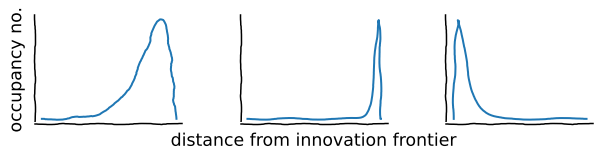

In [64]:
with plt.xkcd(length=0, scale=.5, randomness=20):
    fig, ax = plt.subplots(figsize=(10,2), ncols=3, gridspec_kw={'wspace':.4})
    ax = ax.ravel()
    
    for a in ax:
        a.set(xticks=[], yticks=[])
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

with plt.xkcd(randomness=10, scale=1.1, length=80):
    plt.rc('font', size=25, family='DejaVuSans')

    x = np.arange(dmftmodel[0].n.size)
    ax[0].plot(x, dmftmodel[0].n)
    ax[0].set_ylabel('occupancy no.', fontsize='x-small', labelpad=10)

with plt.xkcd(randomness=4, scale=.8, length=80):
    plt.rc('font', size=25, family='DejaVuSans')
    
    x = np.arange(dmftmodel[6].n.size-8)
    ax[1].plot(x, dmftmodel[6].n[8:])
    ax[1].set_xlabel('distance from innovation frontier', labelpad=8, fontsize='x-small')

    x = np.arange(dmftmodel[4].n.size-30)[::-1]
    ax[2].plot(x, dmftmodel[4].n[30:])

fig.savefig(f'{imgdr}/data_occupancy_top.pdf', bbox_inches='tight')

# Supplementary figures

## Fluctuations
From "2021-11-30 critical point.ipynb"

In [408]:
G = 4
re = .4
rd = .4
I = .05

ro = (2 * re - rd) * .48

usimulator = UnitSimulator(G, ro, re, rd, I, dt=.01,
                           rng=np.random.RandomState(10))

occupancy = []
occupancy.append(usimulator.simulate(1))
for i in range(40_000):
    occupancy.append(usimulator.simulate(1, occupancy=occupancy[-1]))
save_pickle(['occupancy','G','rd','re','I','ro'],
            'plotting/critical_re_occupancy.p.1')

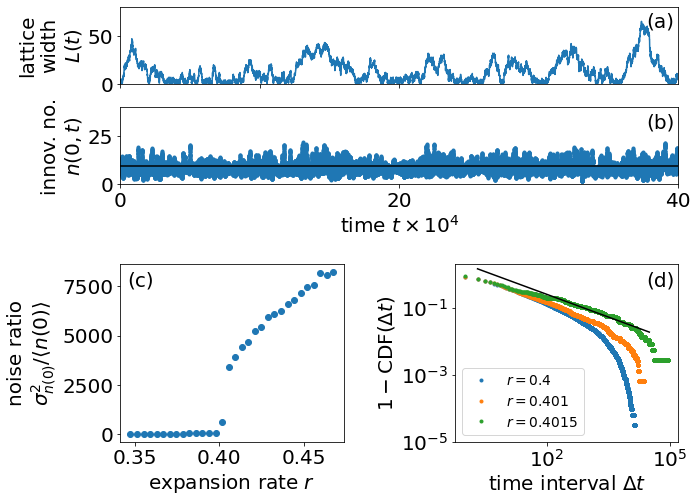

In [10]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2, 2, height_ratios=(1,1), hspace=.45, wspace=.5)
gstop = GridSpecFromSubplotSpec(2, 1, gs[0,:], hspace=.3)
ax = [fig.add_subplot(gstop[0]),
      fig.add_subplot(gstop[1]),
      fig.add_subplot(gs[1,0]),
      fig.add_subplot(gs[1,1])]

load_pickle('plotting/critical_re_occupancy.p')
t = arange(len(occupancy))
ax[0].plot(t, [len(i) for i in occupancy])
ax[0].set(ylabel='lattice\nwidth\n'+r'$L(t)$', ylim=(0, 80),
          xlim=(0, len(occupancy)), xticks=(0,1e4,2e4), xticklabels=[])

ax[1].plot(t[:-20] + 10, fftconvolve([i[-1] for i in occupancy], ones(21)/21, mode='valid'),
           '.', zorder=0)
ax[1].hlines(ro/I/re, 0, len(occupancy), linestyle='-', color='k', zorder=1)
ax[1].set(xlabel=r'time $t\times10^4$', ylabel='innov. no.\n'+r'$n(0,t)$',
          xlim=(0, len(occupancy)), ylim=(0, 40), xticks=(0,2e4,4e4), xticklabels=[0,20,40])


load_pickle('cache/critical_range_I0.05.p')
ax[2].plot(dre + re, noise_ratio**2 * m, 'o')
ax[2].set(xlabel=r'expansion rate $r$',
          ylabel='noise ratio\n'+r'$\sigma_{n(0)}^2/\langle n(0) \rangle$')

load_pickle('plotting/return_time_example.p')
for p_ in p:
    ax[3].loglog(range(1, p_.size), 1-cumsum(p_)[:-1], '.')

x = logspace(.3, 4.5, 100)
# ax.loglog(x, x**-.45/3 * exp(-.35e-3 * x), 'k-')
ax[3].loglog(x, x**-.45*2, 'k-')
ax[3].set(xlabel='time interval $\Delta t$', ylabel=r'$1-{\rm CDF}(\Delta t)$',
          ylim=(1e-5, 2))
ax[3].legend((r'$r=0.4$',r'$r=0.401$',r'$r=0.4015$'), fontsize='x-small')

fig.text(.855, .845, '(a)')
fig.text(.855, .67, '(b)')
fig.text(.135, .395, '(c)')
fig.text(.855, .395, '(d)')

fig.savefig(f'{imgdr}/critical_re.png', bbox_inches='tight', dpi=120)

## Dynamics example

Text(1, 10000.0, '(c)')

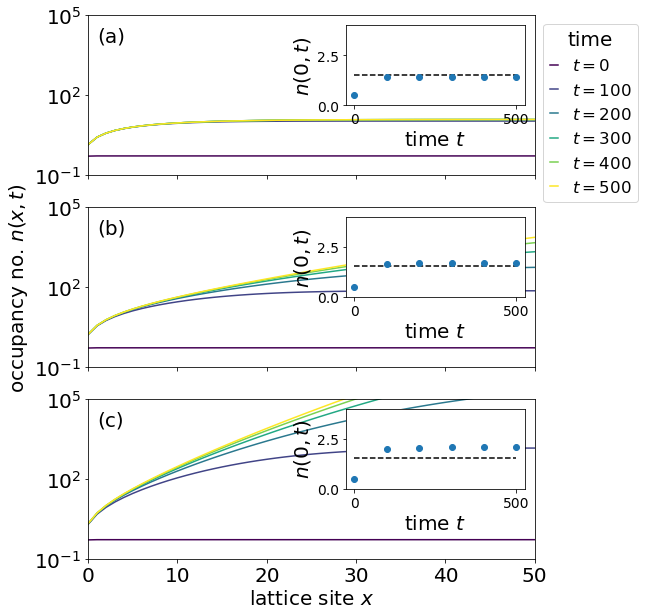

In [8]:
dt = .1
ro = .55

# plotting
fig, ax = plt.subplots(figsize=(8,10), nrows=3,
                       sharex=True, sharey=True,
                       gridspec_kw={'wspace':.4})
ax = ax.ravel()

G = 20
rd = .42
re = .4
I = .9

dmftmodel = FlowMFT(G, ro, re, rd, I, dt)
snapshot_n, t = dmftmodel.run(501, 100)

for i, n in enumerate(snapshot_n):
    ax[0].plot(n, '-', c=plt.cm.viridis(i/(len(snapshot_n)-1)))
ax[0].set(xlim=(0, 50), ylim=(.1, 1e4))
ax[0].set(yscale='log')
ax[0].legend([f'$t={int(i)}$' for i in t], loc=1, bbox_to_anchor=(1.25,1), title='time',
             handlelength=.5, fontsize='small')

axins = inset_axes(ax[0], width="40%", height="50%", loc=1)
axins.plot(t, [i[0] for i in snapshot_n], 'o', zorder=1)
axins.hlines(dmftmodel.n0, 0, t[-1], linestyles='--', color='k', zorder=0)
axins.set(xlabel=r'time $t$', ylabel=r'$n(0,t)$', ylim=(0,4.))
[el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()]
[el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()]


G = 20
rd = .38
re = .4
I = .9

dmftmodel = FlowMFT(G, ro, re, rd, I, dt)
snapshot_n, t = dmftmodel.run(501, 100)

for i, n in enumerate(snapshot_n):
    ax[1].plot(n, '-', c=plt.cm.viridis(i/(len(snapshot_n)-1)))
ax[1].set(xlim=(0, 50), ylim=(.1, 1e4),
          ylabel=r'occupancy no. $n(x,t)$')
ax[1].set(yscale='log')

axins = inset_axes(ax[1], width="40%", height="50%", loc=1)
axins.plot(t, [i[0] for i in snapshot_n], 'o', zorder=1)
axins.hlines(dmftmodel.n0, 0, t[-1], linestyles='--', color='k', zorder=0)
axins.set(xlabel=r'time $t$', ylabel=r'$n(0,t)$', ylim=(0,4.))
[el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()]
[el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()]


G = 20
rd = .34
re = .4
I = .9

dmftmodel = FlowMFT(G, ro, re, rd, I, dt)
snapshot_n, t = dmftmodel.run(501, 100)

for i, n in enumerate(snapshot_n):
    ax[2].plot(n, '-', c=plt.cm.viridis(i/(len(snapshot_n)-1)))
ax[2].set(xlim=(0, 50), ylim=(.1, 1e5),
          xlabel=r'lattice site $x$')
ax[2].set(yscale='log')

axins = inset_axes(ax[2], width="40%", height="50%", loc=1)
axins.plot(t, [i[0] for i in snapshot_n], 'o', zorder=1)
axins.hlines(dmftmodel.n0, 0, t[-1], linestyles='--', color='k', zorder=0)
axins.set(xlabel=r'time $t$', ylabel=r'$n(0,t)$', ylim=(0,4.))
[el.set_fontsize('x-small') for el in axins.xaxis.get_ticklabels()]
[el.set_fontsize('x-small') for el in axins.yaxis.get_ticklabels()]

ax[0].text(1, 1e4, '(a)')
ax[1].text(1, 1e4, '(b)')
ax[2].text(1, 1e4, '(c)')

fig.savefig(f'{imgdr}/dynamics.pdf', bbox_inches='tight')

## Cooperativity example

From "2021-11-25 compare simulations.ipynb"

In [65]:
load_pickle('plotting/cooperativity_ex.p')

['alpha_range', 'dmftmodel', 'automaton']

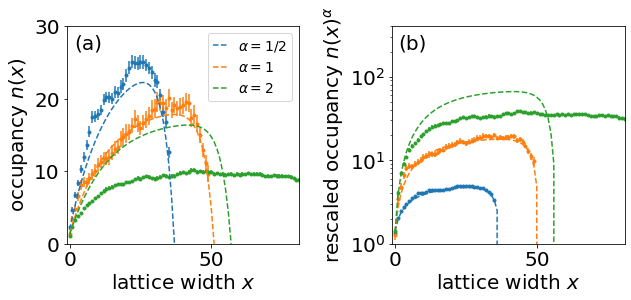

In [67]:
fig, ax = plt.subplots(figsize=(10,4),
                       ncols=2,
                       gridspec_kw={'wspace':.4},
                       sharex=True,
                       sharey=False)

h = []
for model in dmftmodel:
    h.append(ax[0].semilogy(model.n, '--', zorder=1)[0])

for i, model in enumerate(automaton):
    if i<2:
        y = model.mean_occupancy(width=(int(dmftmodel[i].L)-1, int(dmftmodel[i].L)+2))
    else:
        y = model.mean_occupancy()
    h.append(ax[0].errorbar(range(len(y[0])), y[0], y[1], fmt='.', c=f'C{i}', zorder=0)[0])

ax[0].legend(h, (r'$\alpha=1/2$', r'$\alpha=1$', r'$\alpha=2$'), fontsize='x-small', handlelength=1.)
ax[0].set(xlabel=r'lattice width $x$', ylabel=r'occupancy $n(x)$', yscale='linear', ylim=(0,30))


for alpha, model in zip(alpha_range, dmftmodel):
    h.append(ax[1].semilogy(model.n**alpha, '--', zorder=1)[0])

for i, model in enumerate(automaton):
    if i<2:
        y = model.mean_occupancy(width=(int(dmftmodel[i].L)-1, int(dmftmodel[i].L)+2), rescale=True)
    else:
        y = model.mean_occupancy(rescale=True)

    h.append(ax[1].errorbar(range(len(y[0])), y[0], y[1], fmt='.', c=f'C{i}', zorder=0)[0])

ax[1].set(ylim=(1, 400), xlim=(-1, 81),
          xlabel=r'lattice width $x$', ylabel=r'rescaled occupancy $n(x)^\alpha$', yscale='log')

fig.text(.135, .8, '(a)')
fig.text(.585, .8, '(b)')

fig.savefig(f'{imgdr}/cooperativity.pdf', bbox_inches='tight')

## Innovation front MFT comparison

In [174]:
G = 10
rd = .41
re = .4
I = .9
dt = .1

def verify_correction_to_L(ro):
    n0 = ro/re/I

    dmftmodel = FlowMFT(G, ro, re, rd, I, dt, L_method=0)
    flag, mxerr = dmftmodel.solve_stationary()
    uncorrectedn0 = dmftmodel.n[0]
    
    dmftmodel = FlowMFT(G, ro, re, rd, I, dt, L_method=1)
    flag, mxerr = dmftmodel.solve_stationary()
    correctedn0 = dmftmodel.n[0]
    
    return n0, uncorrectedn0, correctedn0

ro_range = linspace(re+1e-3, re+.2, 100) 
with Pool() as pool:
    n0 = vstack(list(pool.map(verify_correction_to_L, ro_range)))

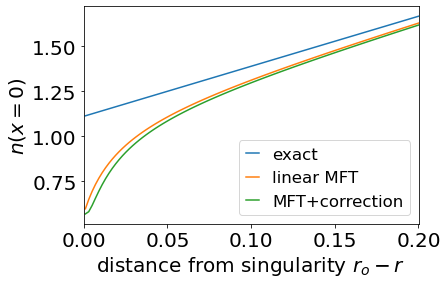

In [175]:
fig, ax = plt.subplots()

ax.plot(ro_range-re, n0[:,0], '-')
ax.plot(ro_range-re, n0[:,1], '-')
ax.plot(ro_range-re, n0[:,2], '-')

ax.set(xlabel=r'distance from singularity $r_o-r$', ylabel=r'$n(x=0)$',
       xlim=(0, (ro_range-re).max()))
ax.legend((r'exact', 'linear MFT', 'MFT+correction'),
          handlelength=.8,
          fontsize='small',
          loc=4)

fig.savefig(f'{imgdr}/mft_correction.pdf', bbox_inches='tight')

## Automaton rescaling

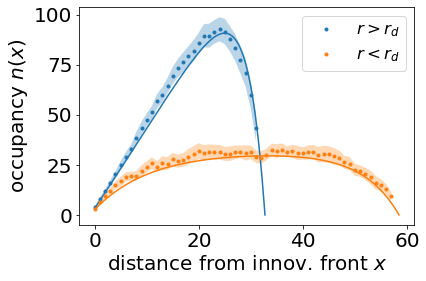

In [14]:
fig, ax = plt.subplots()
h = []

for ix in range(2):
    load_pickle('cache/automaton_rescaling.p')

    c = c[ix]
    occupancy = occupancy[ix]
    L = np.array([(len(i)-1) for i in occupancy])
    n0 = np.array([i[-1] for i in occupancy])

    odemodel = ODE2(*params[ix].values())

    # method of averaging is important
    minlength = int((odemodel.L+1)/c)
    n = np.vstack([i[-minlength+1:][::-1]
                   for i in occupancy
                   if abs(len(i)-minlength)<=1])
    nerr = n.std(0) / np.sqrt(n.shape[0])
    n = n.mean(0)

    # occupancy number
    h.append(ax.plot(arange(n.size), n, '.', c=f'C{ix}')[0])
    ax.fill_between(range(n.size), n-nerr*2, n+nerr*2, alpha=.3)

    rev_params = params[ix].copy()
    rev_params['G'] /= c
    rev_params['innov_rate'] *= c
    odemodel = ODE2(*rev_params.values())
    odemodel.L = odemodel.solve_L(method=3)
    x = np.linspace(0, odemodel.L, 200)
    h.append(ax.plot(x / c, odemodel.n(x) * c, '-', c=f'C{ix}')[0])

ax.set(xlabel=r'distance from innov. front $x$',
       ylabel=r'occupancy $n(x)$')
ax.legend([h[0],h[2]], (r'$r>r_d$', '$r<r_d$'), fontsize='small')

fig.savefig(f'{imgdr}/automaton_rescaling.pdf', bbox_inches='tight')

## Flow over single idea

In [ ]:
def loop_wrapper(re):
    if re==.4:
        G = 10
        ro = .5
        rd = .4
        I = .2
        dt = .01
    else:
        G = 40
        ro = .5
        rd = .4
        I = .2
        dt = .01

    model = FlowMFT(G, ro, re, rd, I, dt)
    model.solve_stationary()
    return model
    
with Pool() as pool:
    dmftmodel = list(pool.map(loop_wrapper, [.39,.4,.41]))

In [ ]:
fig, ax = plt.subplots()

h = []
# why doesn't the other MFT work?
# h.append(ax.semilogy(mftmodel.n, '.-')[0])
for model in dmftmodel:
    area = trapz(model.n, x=linspace(0, 1, model.n.size))
    h.append(ax.semilogy(linspace(0, 1, model.n.size), model.n/area, '.-')[0])

ax.legend(h, (r'$r_e=r_d-10^{-2}$', r'$r_e=r_d$', r'$r_e=r_d+10^{-2}$'),
          fontsize='small')
ax.set(xlabel=r'rescaled lattice index $x/L$', ylabel=r'rescaled occupancy $\tilde{n}(x)$',
       yscale='linear', xlim=(0,1))

fig.savefig(f'{imgdr}/pseudogap.png', bbox_inches='tight', dpi=120)

## Phase space according to second order approximation

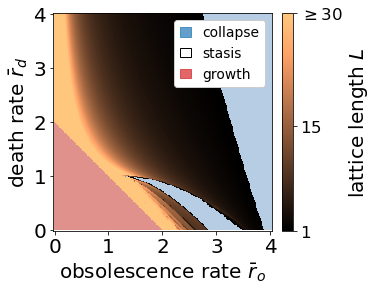

In [173]:
G, ro, re, rd, I, dt = iplot.phase_space_example_params().values()
ro /= re
rd /= re
G /= re

# these should all be points at which the lattice diverges
fig, ax = plt.subplots()

# exact 2st order boundaries
load_pickle('cache/phase_space_ODE2_fine.p')

dro = ro_bar[1]-ro_bar[0]
drd = rd_bar[1]-rd_bar[0]

# static regime
L_ = L.copy()
cm = plt.cm.copper.copy()
im = ax.imshow(L_, vmin=1, vmax=30, origin='lower',
                  extent=[ro_bar[0]-dro, ro_bar[-1]+dro, rd_bar[0]-drd, rd_bar[-1]+drd],
                  cmap=cm, zorder=0)

cmap = colors.ListedColormap(['#E1918B', '#B6CDE3'])
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

# collapse regime
L_ = L.copy()
L_[L>1] = np.nan
L_[L<=1] = 1.5
ax.imshow(L_, origin='lower',
          extent=[ro_bar[0]-dro, ro_bar[-1]+dro, rd_bar[0]-drd, rd_bar[-1]+drd],
          cmap=cmap, norm=norm, zorder=1)

# growth regime
L_ = L.copy()
L_[L>=1e5] = .5
L_[L<1e5] = np.nan
ax.imshow(L_, origin='lower',
          extent=[ro_bar[0]-dro, ro_bar[-1]+dro, rd_bar[0]-drd, rd_bar[-1]+drd],
          cmap=cmap, norm=norm, zorder=2)

cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
cbar = fig.colorbar(im, cax=cax, ticks=[1,15,30], label=r'lattice length $L$')
cbar.ax.set_yticklabels([r'$1$', r'$15$', r'$\geq30$'], size='small') 

ax.set(xlim=(ro_bar[0]-1.5*dro, ro_bar[-1]+1.5*dro),
       ylim=(rd_bar[0]-drd, rd_bar[-1]+drd),
       xticks=range(5), yticks=range(5),
       xlabel=r'obsolescence rate $\bar r_o$',
       ylabel=r'death rate $\bar r_d$');

custom_lines = [Rectangle([0,0], 1, 1, color='C0', alpha=.7),
                Rectangle([0,0], 1, 1, fc='white', ec='k', lw=1),
                Rectangle([0,0], 1, 1, color='C3', alpha=.7)]

ax.legend(custom_lines, ['collapse', 'stasis', 'growth'],
          handlelength=.8, framealpha=1, fontsize='x-small', loc=1)

fig.savefig(f'{imgdr}/phase_space_2ode.pdf', bbox_inches='tight')

## Phase space according to series solution to linear model

/home/eddie/Dropbox/Research/innov/py/pyutils/simple_model.py:91: RuntimeWarning: divide by zero encountered in true_divide
  Returns


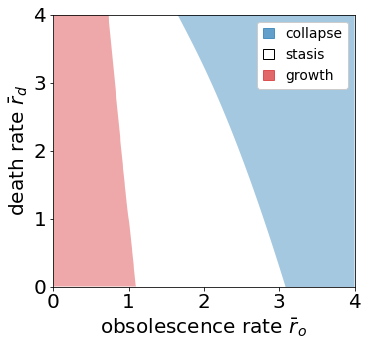

In [167]:
G = 5
I = 1

def growth_cost(rd, ro):
    return L_1ode(G, ro, 1, rd, I, return_denom=True)[1]**2

def collapse_cost(rd, ro, G, I):
    return collapse_condition(ro, rd, G, I, allow_negs=True)**2

# these should all be points at which the lattice diverges
fig, ax = plt.subplots(figsize=(5.4, 5))
# axins = inset_axes(ax, 1.5, 1.5, loc=2)

# growth boundaries
ro_range = linspace(0, 1.4, 400)[1:]
rd_range = []
for ro_ in ro_range:
    sol = minimize(growth_cost, 2-ro_, args=(ro_,), bounds=([0,5],), tol=1e-9)
    rd_range.append(sol['x'][0])
ax.fill_between(ro_range, np.zeros(ro_range.size), rd_range, fc='C3', alpha=.4, lw=0)

ro_range = linspace(1, 4, 200)[1:]
rd_range = []
for ro_ in ro_range:
    sol = minimize(collapse_cost, .9, args=(ro_, G, I))
    if sol['fun']<1e-6:
        rd_range.append(sol['x'][0])
    else:
        rd_range.append(np.nan)
ax.fill_between(ro_range, rd_range, np.zeros(ro_range.size)+10, fc='C0', alpha=.4, lw=0)

custom_lines = [Rectangle([0,0], 1, 1, color='C0', alpha=.7),
                Rectangle([0,0], 1, 1, fc='white', ec='k', lw=1),
                Rectangle([0,0], 1, 1, color='C3', alpha=.7)]

ax.legend(custom_lines, ['collapse', 'stasis', 'growth'],
          handlelength=.8, framealpha=1, fontsize='x-small', loc=1)

ax.set(xlabel=r'obsolescence rate $\bar r_o$',
       ylabel=r'death rate $\bar r_d$', xlim=(0,4), ylim=(0,4))
axins.set(xlim=(0,4), ylim=(0,4), xticks=range(5), yticks=range(5),
          xticklabels=[], yticklabels=[]);

fig.savefig(f'{imgdr}/phase_space_1st.pdf', bbox_inches='tight')

## Covid tree

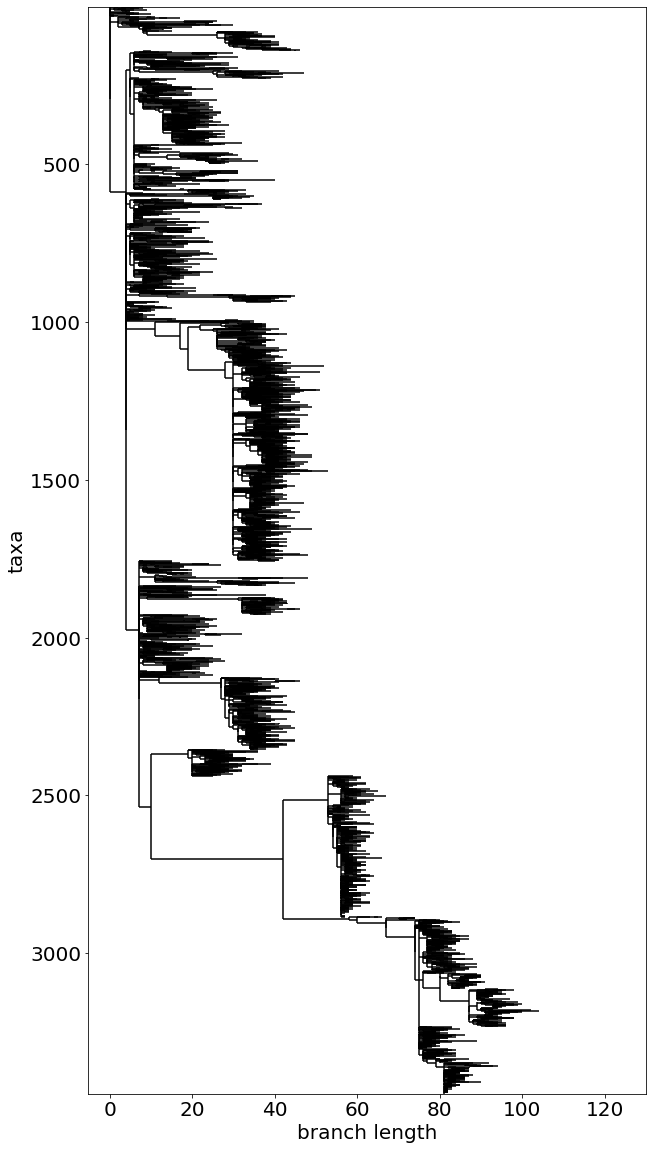

In [151]:
tree = Phylo.read("../data/covid/nextstrain_ncov_gisaid_north-america_all-time_tree.nwk", "newick")

fig, ax = plt.subplots(figsize=(10,20))
Phylo.draw(tree, axes=ax, label_func=lambda x:None)

fig.savefig(f'{imgdr}/covid_tree.pdf', bbox_inches='tight')